## Classificação por isolamento de frequência

Neste notebook será realizado um exemplo de classificação, isolando todas as frequências estimuladas no conjunto de dados `AVI SSVEP Single Target`. 

### Passos para a realização da classificação:

1. **Carrega** o arquivo `fif` (`mne.EpochsArray`) dos dados **filtrados**;
2. **Determine o limiar** para isolar cada uma das frequências estimuladas. Por exemplo, a faixa de frequência para o estímulo de 6.5 Hz irá resultar em pontos (`PSD`) que irão variar de 6.3 à 6.7 Hz, caso o limiar seja de 0.2 Hz;
3. **Obter a "energia"** do sinal por meio do cálculo `compute_psd` para cada uma das faixas de frequência que podem ser estimuladas. Por exemplo:
    - Obtenha todas as frequências estimuladas. Ex: 6, 6.5, 7, 7.5, 8.2 e 9.3;
    - Obtenha o valor mínimo e o máximo para cada frequência utilizando limiar. Ex: (5.8, 6.2), (6.3, 6.7), ...
    - Aplique o `compute_psd` para cada tupla (min, max), por meio dos parâmetros `fmin` e `fmax` do mesmo método.
4. Com as listas de pontos isoladas e computadas (`PSD`) para cada amostra, aplique um cálculo de característica adequada. Características manuais interessantes para este exemplo podem ser `max_value`, `average` ou `median`. No fim deste passo iremos obter um **vetor de características**;
5. Por fim, realize a **classificação**, que será um **cálculo de voto** simples (maior valor é provavelmente o a frequência evocada).

A seguir, um exemplo desta classificação com os dados `single target` de `AVI dataset`:

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Carregamento das bibliotecas que serão utilizadas neste notebook.

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
from sklearn.preprocessing import LabelEncoder
import mne
import warnings

# tarefa 1
data = mne.read_epochs("../../datasets/avi/beta/beta.fif")

Reading c:\RP-BCC\Reconhecimento-de-padroes\SSVEP\src\beta\..\..\datasets\avi\beta\beta.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    1462.89 ms
        0 CTF compensation matrices available
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated


C:\Users\maran\AppData\Local\Temp\ipykernel_30104\3615056382.py:11: RuntimeWarning: This filename (../../datasets/avi/beta/beta.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  data = mne.read_epochs("../../datasets/avi/beta/beta.fif")


In [4]:
# TAREFA 2
threshold = 0.25

# entendimento dos dados
print(data.get_data().shape)
data

(160, 64, 750)


Number of events,160
Events,10.0: 410.2: 410.4: 410.6: 410.8: 411.0: 411.2: 411.4: 411.6: 411.8: 412.0: 412.2: 412.4: 412.6: 412.8: 413.0: 413.2: 413.4: 413.6: 413.8: 414.0: 414.2: 414.4: 414.6: 414.8: 415.0: 415.2: 415.4: 415.6: 415.8: 48.0: 48.2: 48.4: 48.6: 48.8: 49.0: 49.2: 49.4: 49.6: 49.8: 4
Time range,0.000 – 1.463 s
Baseline,off


In [6]:
y = np.load("../../datasets/avi/beta/labels_beta.npy")

print("y", y)
y_set = sorted(set(y))

y [ 8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11.  11.2
 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2 13.4 13.6 13.8 14.
 14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8  8.   8.2  8.4]


In [7]:
ch_names = list(np.load("../../datasets//avi/beta/channels_beta.npy"))

<EpochsFIF |  160 events (all good), 0 – 1.46289 s, baseline off, ~58.7 MB, data loaded,
 '8.0': 4
 '8.2': 4
 '8.4': 4
 '8.6': 4
 '8.8': 4
 '9.0': 4
 '9.2': 4
 '9.4': 4
 '9.6': 4
 '9.8': 4
 and 30 more events ...>


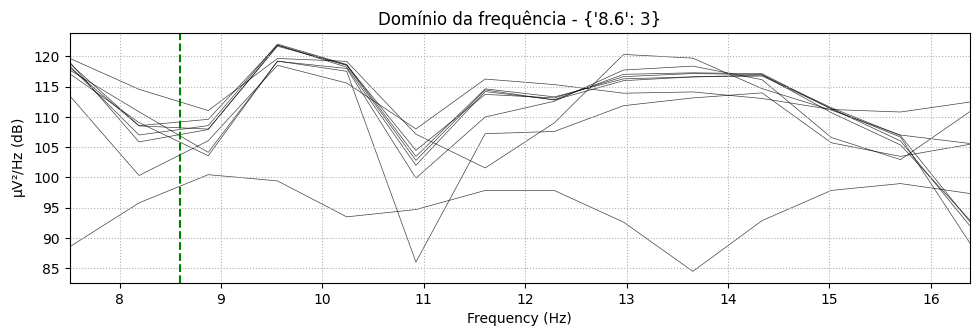

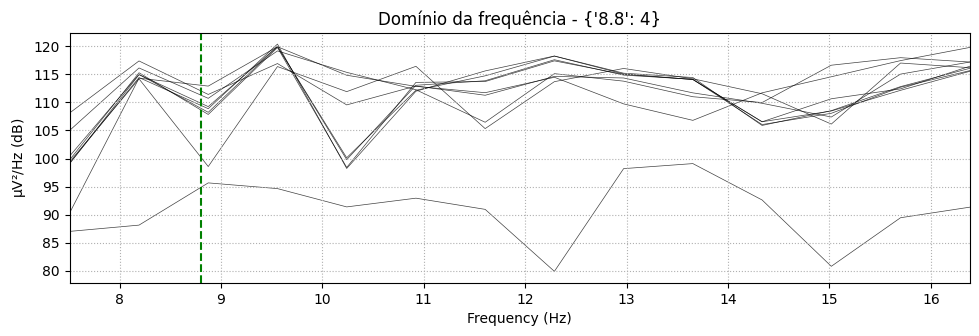

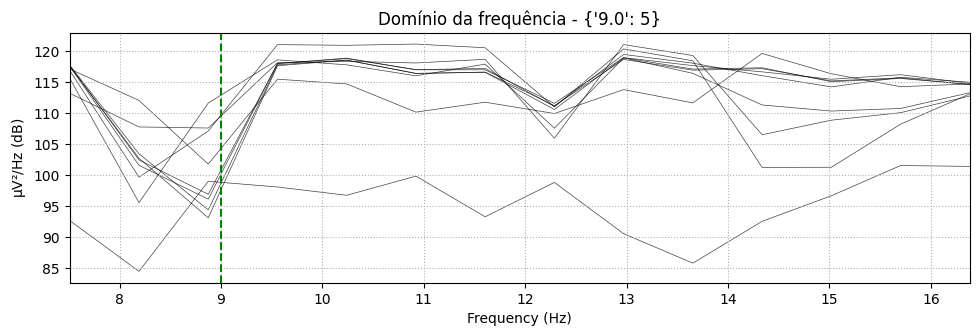

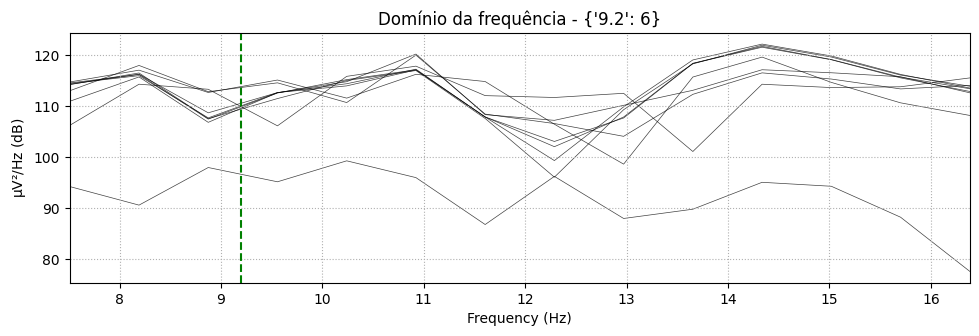

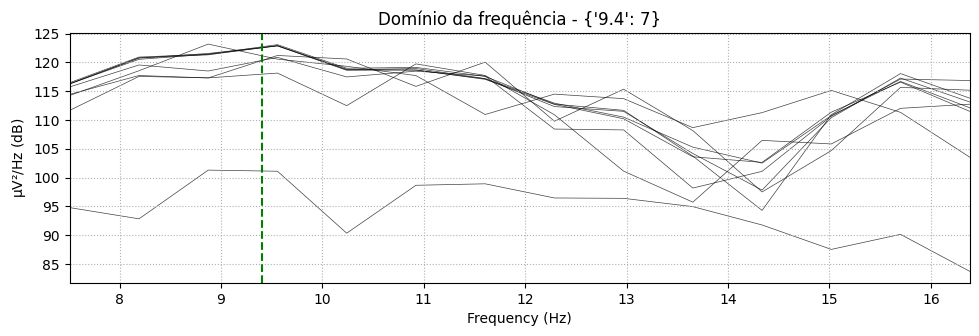

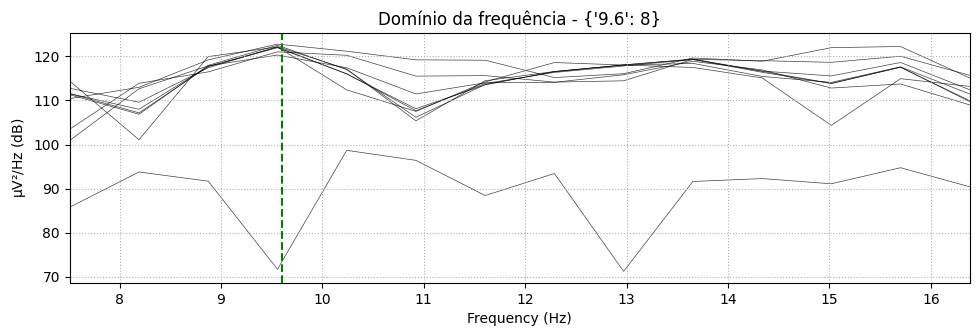

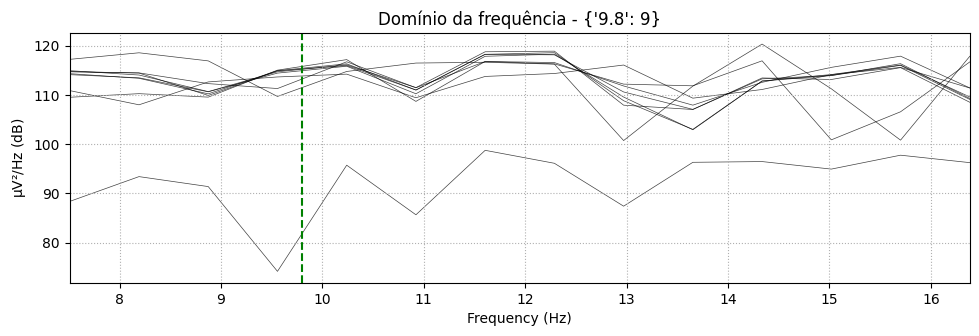

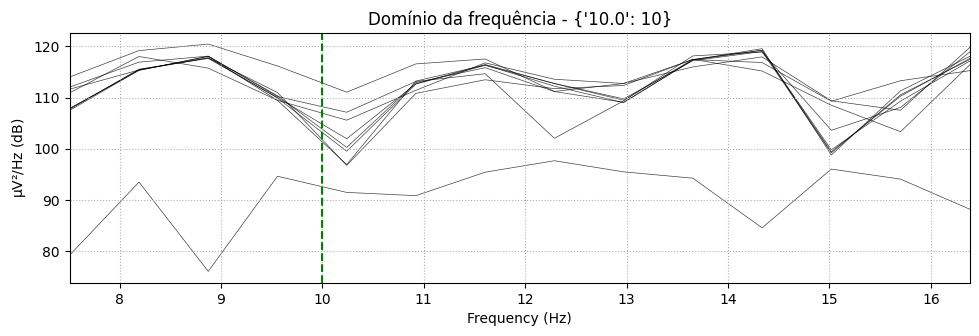

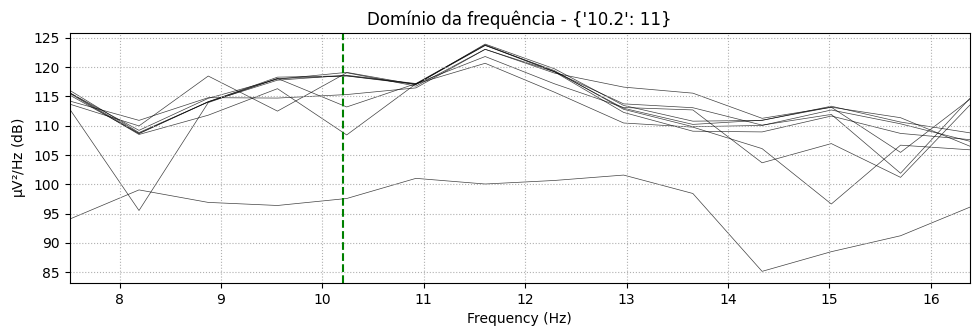

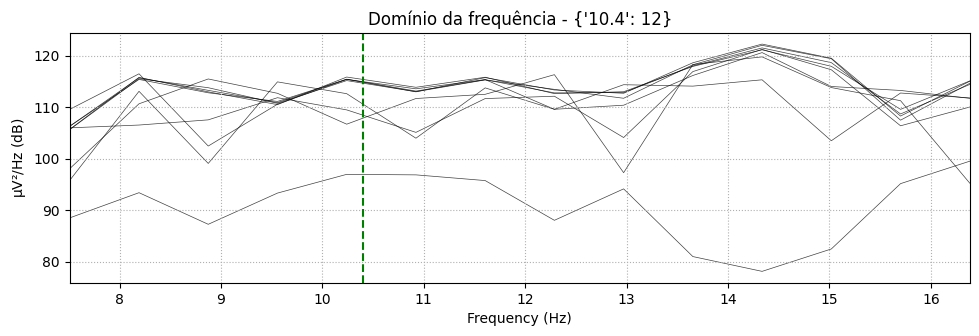

In [9]:
warnings.filterwarnings('ignore')

channels_to_keep = ['PZ', 'PO3', 'PO5', 'PO4', 'PO6', 'POZ', 'O1', 'OZ', 'O2']
channels_to_remove = set(ch_names) - set(channels_to_keep)

print(data)

data = data.drop_channels(list(channels_to_remove))
qtd_data = len(data)

for i in range(0, 10):
    view = data[i].compute_psd(method='welch', fmin=7, fmax=17, verbose=False)
        
    view.plot(show=False)
    plt.title(f'Domínio da frequência - {view.event_id}')
    plt.axvline(x=float(list(data[i].event_id)[0]), linestyle='--', color='green')
    plt.show()

In [10]:
limiar = 1
hits = 0

for i in range(0, qtd_data):
    dict_y = {str(value): index  for index, value in enumerate(y_set)}

    view = data[i].compute_psd(method='welch', fmin=7, fmax=17, verbose=False)

    for frequency in y_set:
        fmin = frequency - limiar
        fmax = frequency + limiar

        array_values = view.get_data(fmin=fmin, fmax=fmax)

        value_view = np.max(array_values)
        # value_view = np.average(array_values)
        # value_view = np.median(array_values)

        dict_y[str(frequency)] = value_view

    target_frequency = max(dict_y, key=dict_y.get)
    if float(target_frequency) == float(list(data[i].event_id)[0]):
        hits += 1

print(f"Percentage: {hits*100/len(y)}")

Percentage: 10.0


In [11]:
limiar = 1
hits = 0

for i in range(0, qtd_data):
  view = data[i].compute_psd(method='welch', fmin=7, fmax=17, verbose=False)


  array_values = view.get_data()

  max_frequency = np.max(array_values)
  print(max_frequency)
  # value_view = np.average(array_values)
  # value_view = np.median(array_values)
  nearest_frequency = y_set[np.abs(y_set - max_frequency).argmin()]
  print(nearest_frequency)

print(f"Percentage: {hits*100/len(y)}")

1.6035773147135712
8.0
1.0976672177023221
8.0
1.3085601117853156
8.0
1.6299530687444146
8.0
2.0816102819650646
8.0
1.9113621771369071
8.0
1.082132078739381
8.0
1.101155877290727
8.0
2.4768870001415006
8.0
1.6906204695476323
8.0
1.3701537891756255
8.0
0.8586072337913371
8.0
1.5821587879115502
8.0
0.9433970301936835
8.0
1.711526158771898
8.0
1.2658728220715365
8.0
1.4528123761725744
8.0
1.2053918694502914
8.0
0.7914114617753494
8.0
1.391823594382648
8.0
0.8075491861457432
8.0
1.9054068851260304
8.0
1.5397815163555673
8.0
1.25439937506481
8.0
1.4307480640227799
8.0
1.5384378500769975
8.0
1.971015380494365
8.0
0.9066180830625679
8.0
2.2729502097694034
8.0
1.493332464906006
8.0
1.3905984928636985
8.0
2.4122100359395655
8.0
1.7808664605236602
8.0
1.1048038464683492
8.0
1.1748351165216229
8.0
1.6506041838022945
8.0
5.543964013314305
8.0
3.447592581098738
8.0
2.3717599414892034
8.0
1.3830901003722433
8.0
1.313575249986611
8.0
1.4600044888417616
8.0
1.6570202746132936
8.0
2.3352341262124274
8.0